In [1]:
from fenics import * # here we need Point
import mshr
import matplotlib.pyplot as plt

N = 32
k = 401
h_air = 4010
h_water = 4.01E6
uf = 280



770.517354446278


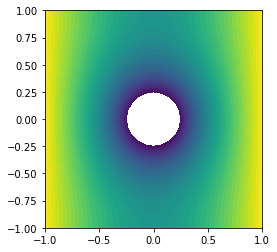

719.6454483390243


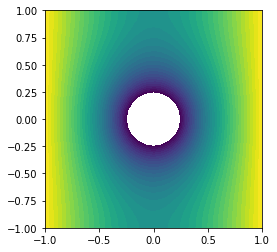

In [18]:
from __future__ import print_function

import numpy as np

r_v = 1

def solver_bcs(kappa, f, boundary_conditions, N,
               degree=1,
               subdomains=[],
               linear_solver='lu',
               abs_tol=1E-5,
               rel_tol=1E-3,
               max_iter=1000):
    """
    Solve -div(kappa*grad(u) = f on (0, 1) x (0, 1) with 2*Nx*Ny Lagrange
    elements of specified degree and u = u_D on the boundary. This version
    of the solver uses a specified combination of Dirichlet, Neumann, and
    Robin boundary conditions.
    """

    domain = mshr.Rectangle(Point(-1, -1), Point(1, 1)) - mshr.Circle(Point(0, 0), 0.25)
    mesh = mshr.generate_mesh(domain, N) # i.e. N = 32
    V = FunctionSpace(mesh, 'P', degree)

    # Check if we have subdomains
    if subdomains:
        if not isinstance(kappa, (list, tuple, np.ndarray)):
            raise TypeError(
                'kappa must be array if we have sudomains, not %s'
                % type(kappa))
        materials = CellFunction('size_t', mesh)
        materials.set_all(0)
        for m, subdomain in enumerate(subdomains[1:], 1):
            subdomain.mark(materials, m)

        kappa_values = kappa
        V0 = FunctionSpace(mesh, 'DG', 0)
        kappa  = Function(V0)
        help = np.asarray(materials.array(), dtype=np.int32)
        kappa.vector()[:] = np.choose(help, kappa_values)
    else:
        if not isinstance(kappa, (Expression, Constant)):
            raise TypeError(
                'kappa is type %s, must be Expression or Constant'
                % type(kappa))

    # Define boundary subdomains
    tol = 1e-14

    class BoundaryX0(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], -1, tol)

    class BoundaryX1(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 1, tol)

    class BoundaryY0(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[1], -1, tol)

    class BoundaryY1(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[1], 1, tol)
    class Circle(SubDomain):
        def inside(self, x, on_boundary):
            tol = 1e-2
            radius = 0.25
            return on_boundary and (abs(x[0]**2 + x[1]**2 - radius**2) <= tol)

    # Mark boundaries
    boundary_markers = MeshFunction('size_t', mesh, mesh.topology().dim() - 1) 
    boundary_markers.set_all(9999)
    bx0 = BoundaryX0()
    bx1 = BoundaryX1()
    by0 = BoundaryY0()
    by1 = BoundaryY1()
    bc = Circle()
    bx0.mark(boundary_markers, 0)
    bx1.mark(boundary_markers, 1)
    by0.mark(boundary_markers, 2)
    by1.mark(boundary_markers, 3)
    bc.mark(boundary_markers, 4)

    # Redefine boundary integration measure
    ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

    # Collect Dirichlet conditions
    bcs = []
    for i in boundary_conditions:
        if 'Dirichlet' in boundary_conditions[i]:
            bc = DirichletBC(V, boundary_conditions[i]['Dirichlet'],
                             boundary_markers, i)
            bcs.append(bc)

    # Define trial and test functions
    u = TrialFunction(V)
    v = TestFunction(V)

    # Collect Neumann integrals
    integrals_N = []
    for i in boundary_conditions:
        if 'Neumann' in boundary_conditions[i]:
            if boundary_conditions[i]['Neumann'] != 0:
                g = boundary_conditions[i]['Neumann']
                integrals_N.append(g*v*ds(i))

    # Collect Robin integrals
    integrals_R_a = []
    integrals_R_L = []
    for i in boundary_conditions:
        if 'Robin' in boundary_conditions[i]:
            r, s = boundary_conditions[i]['Robin']
            integrals_R_a.append(r*u*v*ds(i))
            integrals_R_L.append(r*s*v*ds(i))

    # Simpler Robin integrals
    integrals_R = []
    for i in boundary_conditions:
        if 'Robin' in boundary_conditions[i]:
            r, s = boundary_conditions[i]['Robin']
            integrals_R.append(r*(u - s)*v*ds(i))

    # Sum integrals to define variational problem
    a = kappa*dot(grad(u), grad(v))*dx + sum(integrals_R_a)
    L = f*v*dx - sum(integrals_N) + sum(integrals_R_L)

    # Simpler variational problem
    F = kappa*dot(grad(u), grad(v))*dx + sum(integrals_R) - f*v*dx + sum(integrals_N)
    a, L = lhs(F), rhs(F)

    # Compute solution
    u = Function(V)
    solve(a == L, u, bcs)

    return u

def demo_bcs(case):
    "Compute and plot solution using a combination of boundary conditions"
    mu = Constant(k)
    # Define manufactured solution in sympy and derive f, g, etc.
    import sympy as sym
    x, y = sym.symbols('x[0], x[1]')# needed by UFL
    u = sym.symbols('u')
    f = - sym.diff(u, x, 2) - sym.diff(u, y, 2)   # -Laplace(u)
    f = sym.simplify(f)                         # simplify f
    
    if case == 1 or case == 2:  
        if case == 1:
            rc = h_air
        if case == 2:
            rc = h_water
        u_00 = 1000  
        u_01 = 1000
        g_10 = 0
        g_11 = 0
        sc = uf
         
                  # simplify f
         # Collect variables
        variables = [rc, sc, g_11, g_11, u_00, u_01, f]

        # Turn into C/C++ code strings
        variables = [sym.printing.ccode(var) for var in variables]

        # Turn into FEniCS Expressions
        variables = [Expression(var, degree=2) for var in variables]

        # Extract variables
        rc, sc, g_11, g_11, u_00, u_01, f = variables

        # Define boundary conditions
        boundary_conditions = {0: {'Dirichlet': u_00},   # x = 0
                               1: {'Dirichlet': u_01},   # x = 1
                               2: {'Neumann': g_10},   # y = 0
                               3: {'Neumann': g_11},   # y = 1
                               4: {'Robin': (rc, sc)}}
    
        

   

    # Compute solution
    
    Nx = Ny = 8
    u = solver_bcs(mu, f, boundary_conditions, N,
                   degree=1, linear_solver='direct')

    # Compute maximum error at vertices
    # Save and plot solution
    vtkfile = File('heat/solution_bcs_' + str(case) + '.pvd')
    print(assemble(u*dx)/(2*2 - np.pi*0.25*0.25))
    vtkfile << u
    plot(u)

    
#case = int(input('Pick a case: '))
demo_bcs(1)
plt.show()
demo_bcs(2)
plt.show()